# Figure S3: Total estimated effort and water drops collected across action cost conditions

## imports and setup

In [1]:
import fnmatch
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from scipy.ndimage import gaussian_filter as smooth

from sessionlists import (dist60, dist90, dist120, TM20, TM10, TM2, TMrev2, TMrev10, TMrev20)
from utils import *
from plotting import *
from model_functions import *
from process_functions import fixcamglitch, fix_start_session

plt.style.use('./Figures/paper.mplstyle')

In [2]:
# Define folder with data
root = "/home/thomas/Desktop/ALLDATA"

print("Path to data is: %s"%root)
print(f'Found {len(glob.glob(root+"/*"))} rats in the data folder')

Path to data is: /home/thomas/Desktop/ALLDATA
Found 34 rats in the data folder


In [3]:
params = {}
rat_markers = {}
sequence = {}
XtrackRunToLeftBin, XtrackRunToRightBin = {}, {}


animalList = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
              'RatF30', 'RatF31', 'RatF32', 'RatF33', 'RatM30', 'RatM31', 'RatM32', 
              'RatF40', 'RatF41', 'RatF42', 'RatM40', 'RatM41', 'RatM42', 'RatM43', 
                'RatF50', 'RatF51', 'RatF52', 'RatM50', 'RatM51', 'RatM52', 'RatM53', 'RatM54']

lesioned = ['RatF30', 'RatF31', 'RatM30', 'RatF40', 'RatF41', 'RatM41', 'RatM42',
            'RatF50', 'RatF51', 'RatF52', 'RatM50', 'RatM51', 'RatM52']

intact = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
            'RatF32', 'RatF33', 'RatM31', 'RatM32', 'RatF42', 'RatM40', 'RatM43', 
            'RatM53', 'RatM54']

rat_example_intact = 'RatM00'
rat_example_lesion = 'RatF52'#'RatF50': # 'RatF52'

m, f = 0, 0
male_palette = create_teal_palette(num_shades=len([x for x in intact if 'M' in x]))
female_palette = create_blue_violet_palette(num_shades=len([x for x in intact if 'F' in x]), start_intensity=80)

for index, animal in enumerate(intact):
    print(f'Loading data for {animal}')
    # define marker and color for each rat, used in plots
    if fnmatch.fnmatch(animal, 'RatF*'):
        rat_markers[animal]=[female_palette[f], 'o', '-']
        f += 1
    elif fnmatch.fnmatch(animal, 'RatM*'):
        rat_markers[animal]=[male_palette[m], 'o', '-']
        m += 1
    elif fnmatch.fnmatch(animal, 'Rat00*'):
        rat_markers[animal]=[(0.0, 0.0, 0.0), "$\u2426$",]
    else:
        print("error, this is not a rat you got here")

    for session in sorted(matchsession(animal, dist60+dist90+dist120 + TM20+TM10+TM2+TMrev2+TMrev10+TMrev20)):
        sequence[animal, session] = get_from_pickle(root, animal, session, name="sequence.p")
        params[animal, session] = get_from_pickle(root, animal, session, name="params.p")

weights = {}
for animal in intact:
    weights[animal] = []
    for session in matchsession(animal, dist60+dist90+dist120+TM20+TM10+TM2+TMrev2+TMrev10+TMrev20):
        weights[animal].extend([params[animal, session]['weight']])
    weights[animal] = sum(weights[animal]) / len(weights[animal])
print(weights)


Loading data for RatF00
Loading data for RatF01
Loading data for RatF02
Loading data for RatM00
Loading data for RatM01
Loading data for RatM02
Loading data for RatF32
Loading data for RatF33
Loading data for RatM31
Loading data for RatM32
Loading data for RatF42
Loading data for RatM40
Loading data for RatM43
Loading data for RatM53
Loading data for RatM54
{'RatF00': 212.0212765957447, 'RatF01': 205.85106382978722, 'RatF02': 193.75, 'RatM00': 259.375, 'RatM01': 278.125, 'RatM02': 253.19148936170214, 'RatF32': 209.58333333333334, 'RatF33': 214.6875, 'RatM31': 279.5833333333333, 'RatM32': 259.1666666666667, 'RatF42': 206.54761904761904, 'RatM40': 238.69565217391303, 'RatM43': 262.2340425531915, 'RatM53': 265.4255319148936, 'RatM54': 280.0}


## compute total effort, distance, rewards

In [4]:

def get_session_total_dist_and_effort(root, weights, animal, session):
    '''get the total effort expended in a session in Joules'''
    pos = read_csv_pandas((root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".position"), Col=[4])[:90000]/11
    time = read_csv_pandas((root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".position"), Col=[3])[:90000]
    cameraEdit = read_csv_pandas((root+os.sep+animal+os.sep+"Experiments"+os.sep + session + os.sep+session+".position"), Col=[11])[:90000]
     
    pos, cameraEdit = fix_start_session(pos, cameraEdit)
    pos = fixcamglitch(time, pos, cameraEdit)
    pos = smooth(np.array(pos, dtype=float), 2)
    w = weights[animal]/1000
    alpha = 1
    beta = 0

    # correct distance for treadmill speed
    tm_speed = get_from_pickle(root, animal, session, name="params.p")['treadmillSpeed'][0]

    TM1_pfPOS = [16.1, 97.3]
    TM2_pfPOS = [17.2, 98.1]

    D = abs(np.diff(pos)/100)
    correction = np.zeros(len(D))
    for idx, (pos, dist) in enumerate(zip(pos, D)):
        if TM1_pfPOS[0] < pos < TM1_pfPOS[1]:
            dist -= tm_speed/100 * 0.04
            correction[idx] = dist if dist > 0 else 0

    instant_effort = ((alpha * w * (correction ** 2)) / np.diff(time)) + beta * w * np.diff(time)
    # instant_effort = ((alpha * w * (abs(np.diff(pos)/100) ** 2)) / np.diff(time)) + beta * w * np.diff(time)
    instant_effort = np.insert(instant_effort, 0, beta * w * 0.04)


    tot = [0]
    tot.extend(correction)
    totaldist = np.cumsum(tot)
    return totaldist[-1], np.cumsum(instant_effort)[-1]

def get_session_total_drops(sequence):
    totaldrops = 0
    for elem in sequence:
        if sequence[elem][1] == 'run':
            if sequence[elem][2] == 1:
                totaldrops += 1
    return totaldrops


conds = ['60', '90', '120', '20', '10', '2', 'rev10', 'rev20']
sessionlists = [dist60, dist90, dist120, TM20, TM10, TM2+TMrev2, TMrev10, TMrev20]

if os.path.exists("picklejar/totaldist_totaldrops_totaleffort.p"):
    total_dist_by_animal, total_drops_by_animal, total_effort_by_animal = pickle.load(open("picklejar/totaldist_totaldrops_totaleffort.p", "rb"))
else:
    total_dist_by_animal = {a: {c:[] for c in conds} for a in animalList}
    total_drops_by_animal = {a: {c:[] for c in conds} for a in animalList}
    total_effort_by_animal = {a: {c:[] for c in conds} for a in animalList}

    for jdx, (sessionList, cond) in enumerate(zip(sessionlists, conds)):
        print(cond)
        for idx, animal in enumerate(animalList):
            for session in matchsession(animal, sessionList):
                if not 'L' in session:
                    dist, eff = get_session_total_dist_and_effort(root, weights, animal, session)
                    drops = get_session_total_drops(sequence[animal, session])

                    total_dist_by_animal[animal][cond].append(dist)
                    total_drops_by_animal[animal][cond].append(drops)
                    total_effort_by_animal[animal][cond].append(eff)

    pickle.dump([total_dist_by_animal, total_drops_by_animal, total_effort_by_animal], open("picklejar/totaldist_totaldrops_totaleffort.p", "wb"))


# subplots

Total effort: p_s=0.000, p_i=0.000, obs_slope=39.986, obs_intercept=18.604
Total effort: p_s=0.000, p_i=0.000, obs_slope=17.643, obs_intercept=75.251


/home/thomas/Documents/RunningFastAndSlow/.venv/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Total drops: p_s=0.034, p_i=0.000, obs_slope=-35.400, obs_intercept=477.633
Total drops: p_s=0.010, p_i=0.000, obs_slope=-14.457, obs_intercept=450.447


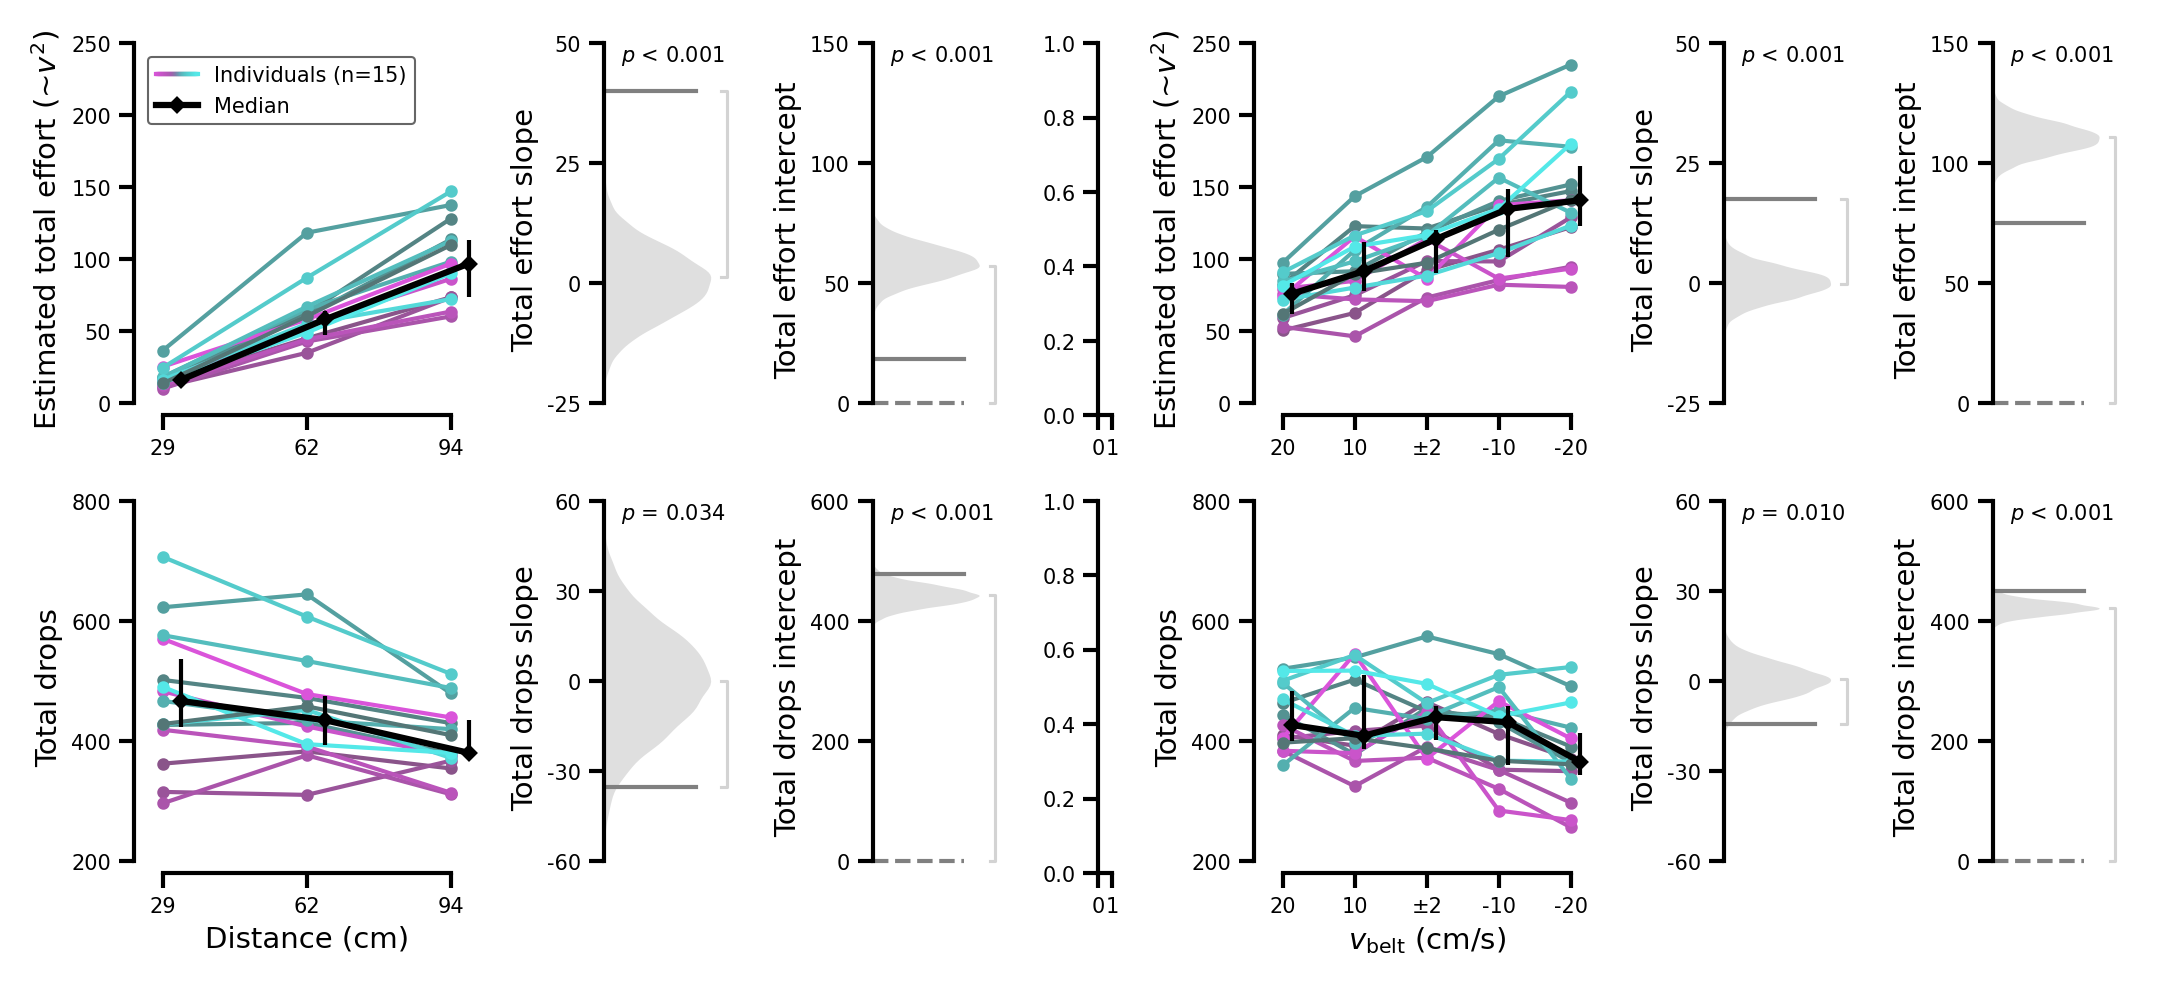

In [5]:
def FigureS3A(ax=None, show_xlabel=False):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))
    conds = ["60", "90", "120"]
    total_dist_by_animal, total_drops_by_animal, total_effort_by_animal = pickle.load(open("picklejar/totaldist_totaldrops_totaleffort.p", "rb"))

    for animal in intact:
        data = np.array([np.median(total_effort_by_animal[animal][cond]) for cond in conds])
        zorder = 5 if animal == 'RatM00' else 2
        ax.plot([0, 1, 2], data, color=rat_markers[animal][0], marker=rat_markers[animal][1], markersize=2, zorder=zorder)

    ax.set_xlim(0, 2)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["29", "62", "94"])
    if show_xlabel:
        ax.set_xlabel("Distance (cm)")
    ax.set_ylabel('Estimated total effort (~$v^2$)')
    ax.set_ylim(0, 250)
    ax.set_yticks([0, 50, 100, 150, 200, 250])

    # ax.set_xlabel('condition')
    space_axes(ax, x_ratio_left=.1, x_ratio_right=.1)
    mediandata = {animal: {cond: np.median(total_effort_by_animal[animal][cond]) for cond in conds} for animal in intact}
    plotmedian(mediandata, ax=ax, dist_or_tm='dist', animalList=intact, err='percentile', label=False)
    median = ax.plot([-100, -101], [-100, -101], color='k', marker='D', markersize=2, linestyle='-', lw=1.5, label=f'Median', zorder=5)


    add_colored_intact(ax, handles=[median],
                    labels=['Median'], text=f'Individuals (n={len(intact)})', 
                    loc='upper left', bbox=(.01, .99))

def FigureS3B(ax=None, show_xlabel=False):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))
    conds = ["20", "10", "2", "rev10", "rev20"]
    total_dist_by_animal, total_drops_by_animal, total_effort_by_animal = pickle.load(open("picklejar/totaldist_totaldrops_totaleffort.p", "rb"))

    for animal in intact:
        data = np.array([np.median(total_effort_by_animal[animal][cond]) for cond in conds])
        zorder = 5 if animal == 'RatM00' else 2
        ax.plot([0, 1, 2, 3, 4], data, color=rat_markers[animal][0], marker=rat_markers[animal][1], 
                markersize=2, zorder=zorder, label=f'Individuals (n={len(animalList)})')

    ax.set_xlim(0, 4)
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_xticklabels(["20", "10", "±2", "-10", "-20"])
    if show_xlabel:
        _ = r'$v_{\mathrm{belt}}$'
        ax.set_xlabel(f'{_} (cm/s)')
    ax.set_ylabel('Estimated total effort (~$v^2$)')
    ax.set_ylim(0, 250)
    ax.set_yticks([0, 50, 100, 150, 200, 250])

    space_axes(ax, x_ratio_left=.1, x_ratio_right=.1)
    mediandata = {animal: {cond: np.median(total_effort_by_animal[animal][cond]) for cond in conds} for animal in intact}
    plotmedian(mediandata, ax=ax, dist_or_tm='tm', animalList=intact, err='percentile')

def FigureS3C(ax=None, show_xlabel=False):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))
    conds = ["60", "90", "120"]
    total_dist_by_animal, total_drops_by_animal, total_effort_by_animal = pickle.load(open("picklejar/totaldist_totaldrops_totaleffort.p", "rb"))

    for animal in intact:
        data = np.array([np.median(total_drops_by_animal[animal][cond]) for cond in conds])
        zorder = 5 if animal == 'RatM00' else 2
        ax.plot([0, 1, 2], data, color=rat_markers[animal][0], marker=rat_markers[animal][1], 
                markersize=2, zorder=zorder, label=f'Individuals (n={len(animalList)})')

    ax.set_xlim(0, 2)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["29", "62", "94"])
    if show_xlabel:
        ax.set_xlabel("Distance (cm)")
    ax.set_ylabel('Total drops')
    ax.set_ylim(200, 800)
    ax.set_yticks([200, 400, 600, 800])

    # ax.set_xlabel('condition')
    space_axes(ax, x_ratio_left=.1, x_ratio_right=.1)
    mediandata = {animal: {cond: np.median(total_drops_by_animal[animal][cond]) for cond in conds} for animal in intact}
    plotmedian(mediandata, ax=ax, dist_or_tm='dist', animalList=intact, err='percentile')

def FigureS3D(ax=None, show_xlabel=False):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))
    conds = ["20", "10", "2", "rev10", "rev20"]
    total_dist_by_animal, total_drops_by_animal, total_effort_by_animal = pickle.load(open("picklejar/totaldist_totaldrops_totaleffort.p", "rb"))
    mediandata = {animal: {cond: np.median(total_drops_by_animal[animal][cond]) for cond in conds} for animal in intact}
    for animal in intact:
        data = np.array([np.median(total_drops_by_animal[animal][cond]) for cond in conds])
        zorder = 5 if animal == 'RatM00' else 2
        ax.plot([0, 1, 2, 3, 4], data, color=rat_markers[animal][0], marker=rat_markers[animal][1], 
                markersize=2, zorder=zorder, label=f'Individuals (n={len(animalList)})')

    ax.set_xlim(0, 4)
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_xticklabels(["20", "10", "±2", "-10", "-20"])
    if show_xlabel:
        _ = r'$v_{\mathrm{belt}}$'
        ax.set_xlabel(f'{_} (cm/s)')
    ax.set_ylabel('Total drops')
    ax.set_ylim(200, 800)
    ax.set_yticks([200, 400, 600, 800])

    # ax.set_xlabel('condition')
    space_axes(ax, x_ratio_left=.1, x_ratio_right=.1)
    mediandata = {animal: {cond: np.median(total_drops_by_animal[animal][cond]) for cond in conds} for animal in intact}
    plotmedian(mediandata, ax=ax, dist_or_tm='tm', animalList=intact, err='percentile')


def FigureS3A_stats(ax_slope=None, ax_intercept=None):
    if ax_slope is None or ax_intercept is None:
        _, (ax_slope, ax_intercept) = plt.subplots(1, 2, figsize=(10, 5))
    conds = ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]
    total_dist_by_animal, total_drops_by_animal, total_effort_by_animal = pickle.load(open("picklejar/totaldist_totaldrops_totaleffort.p", "rb"))
    mediandata = {animal: {cond: np.median(total_effort_by_animal[animal][cond]) for cond in conds} for animal in intact}
    regression_permutation(mediandata, dist_or_tm='dist', varname='Total effort', 
                        ax_slope=ax_slope, yticks_slope=[-25, 0, 25, 50], 
                        ax_intercept=ax_intercept, y_ticks_intercept=[0, 50, 100, 150])

def FigureS3B_stats(ax_slope=None, ax_intercept=None):
    if ax_slope is None or ax_intercept is None:
        _, (ax_slope, ax_intercept) = plt.subplots(1, 2, figsize=(10, 5))
    conds = ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]
    total_dist_by_animal, total_drops_by_animal, total_effort_by_animal = pickle.load(open("picklejar/totaldist_totaldrops_totaleffort.p", "rb"))
    mediandata = {animal: {cond: np.median(total_effort_by_animal[animal][cond]) for cond in conds} for animal in intact}
    regression_permutation(mediandata, dist_or_tm='tm', varname='Total effort', 
                        ax_slope=ax_slope, yticks_slope=[-25, 0, 25, 50], 
                        ax_intercept=ax_intercept, y_ticks_intercept=[0, 50, 100, 150])
    
def FigureS3C_stats(ax_slope=None, ax_intercept=None):
    if ax_slope is None or ax_intercept is None:
        _, (ax_slope, ax_intercept) = plt.subplots(1, 2, figsize=(10, 5))
    conds = ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]
    total_dist_by_animal, total_drops_by_animal, total_effort_by_animal = pickle.load(open("picklejar/totaldist_totaldrops_totaleffort.p", "rb"))
    mediandata = {animal: {cond: np.median(total_drops_by_animal[animal][cond]) for cond in conds} for animal in intact}
    regression_permutation(mediandata, dist_or_tm='dist', varname='Total drops', 
                        ax_slope=ax_slope, yticks_slope=[-60, -30, 0, 30, 60],
                        ax_intercept=ax_intercept, y_ticks_intercept=[0, 200, 400, 600])

def FigureS2D_stats(ax_slope=None, ax_intercept=None):
    if ax_slope is None or ax_intercept is None:
        _, (ax_slope, ax_intercept) = plt.subplots(1, 2, figsize=(10, 5))
    conds = ["60", "90", "120", "20", "10", "2", "rev10", "rev20"]
    total_dist_by_animal, total_drops_by_animal, total_effort_by_animal = pickle.load(open("picklejar/totaldist_totaldrops_totaleffort.p", "rb"))
    mediandata = {animal: {cond: np.median(total_drops_by_animal[animal][cond]) for cond in conds} for animal in intact}
    regression_permutation(mediandata, dist_or_tm='tm', varname='Total drops', 
                        ax_slope=ax_slope, yticks_slope=[-60, -30, 0, 30, 60],
                        ax_intercept=ax_intercept, y_ticks_intercept=[0, 200, 400, 600])

fig, axs = plt.subplots(2, 7, figsize=(cm2inch(18), cm2inch(8)), gridspec_kw={'width_ratios': [2.5, 1, 1, .1, 2.5, 1, 1]})
FigureS3A(ax=axs[0, 0])
FigureS3B(ax=axs[0, 4])
FigureS3C(ax=axs[1, 0], show_xlabel=True)
FigureS3D(ax=axs[1, 4], show_xlabel=True)


FigureS3A_stats(ax_slope=axs[0, 1], ax_intercept=axs[0, 2])
FigureS3B_stats(ax_slope=axs[0, 5], ax_intercept=axs[0, 6])
FigureS3C_stats(ax_slope=axs[1, 1], ax_intercept=axs[1, 2])
FigureS2D_stats(ax_slope=axs[1, 5], ax_intercept=axs[1, 6])

# Figure S3: Total estimated effort and water drops collected across action cost conditions

Total effort: p_s=0.000, p_i=0.000, obs_slope=39.986, obs_intercept=18.604
Total effort: p_s=0.000, p_i=0.000, obs_slope=17.643, obs_intercept=75.251


/home/thomas/Documents/RunningFastAndSlow/.venv/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Total drops: p_s=0.034, p_i=0.000, obs_slope=-35.400, obs_intercept=477.633
Total drops: p_s=0.010, p_i=0.000, obs_slope=-14.457, obs_intercept=450.447


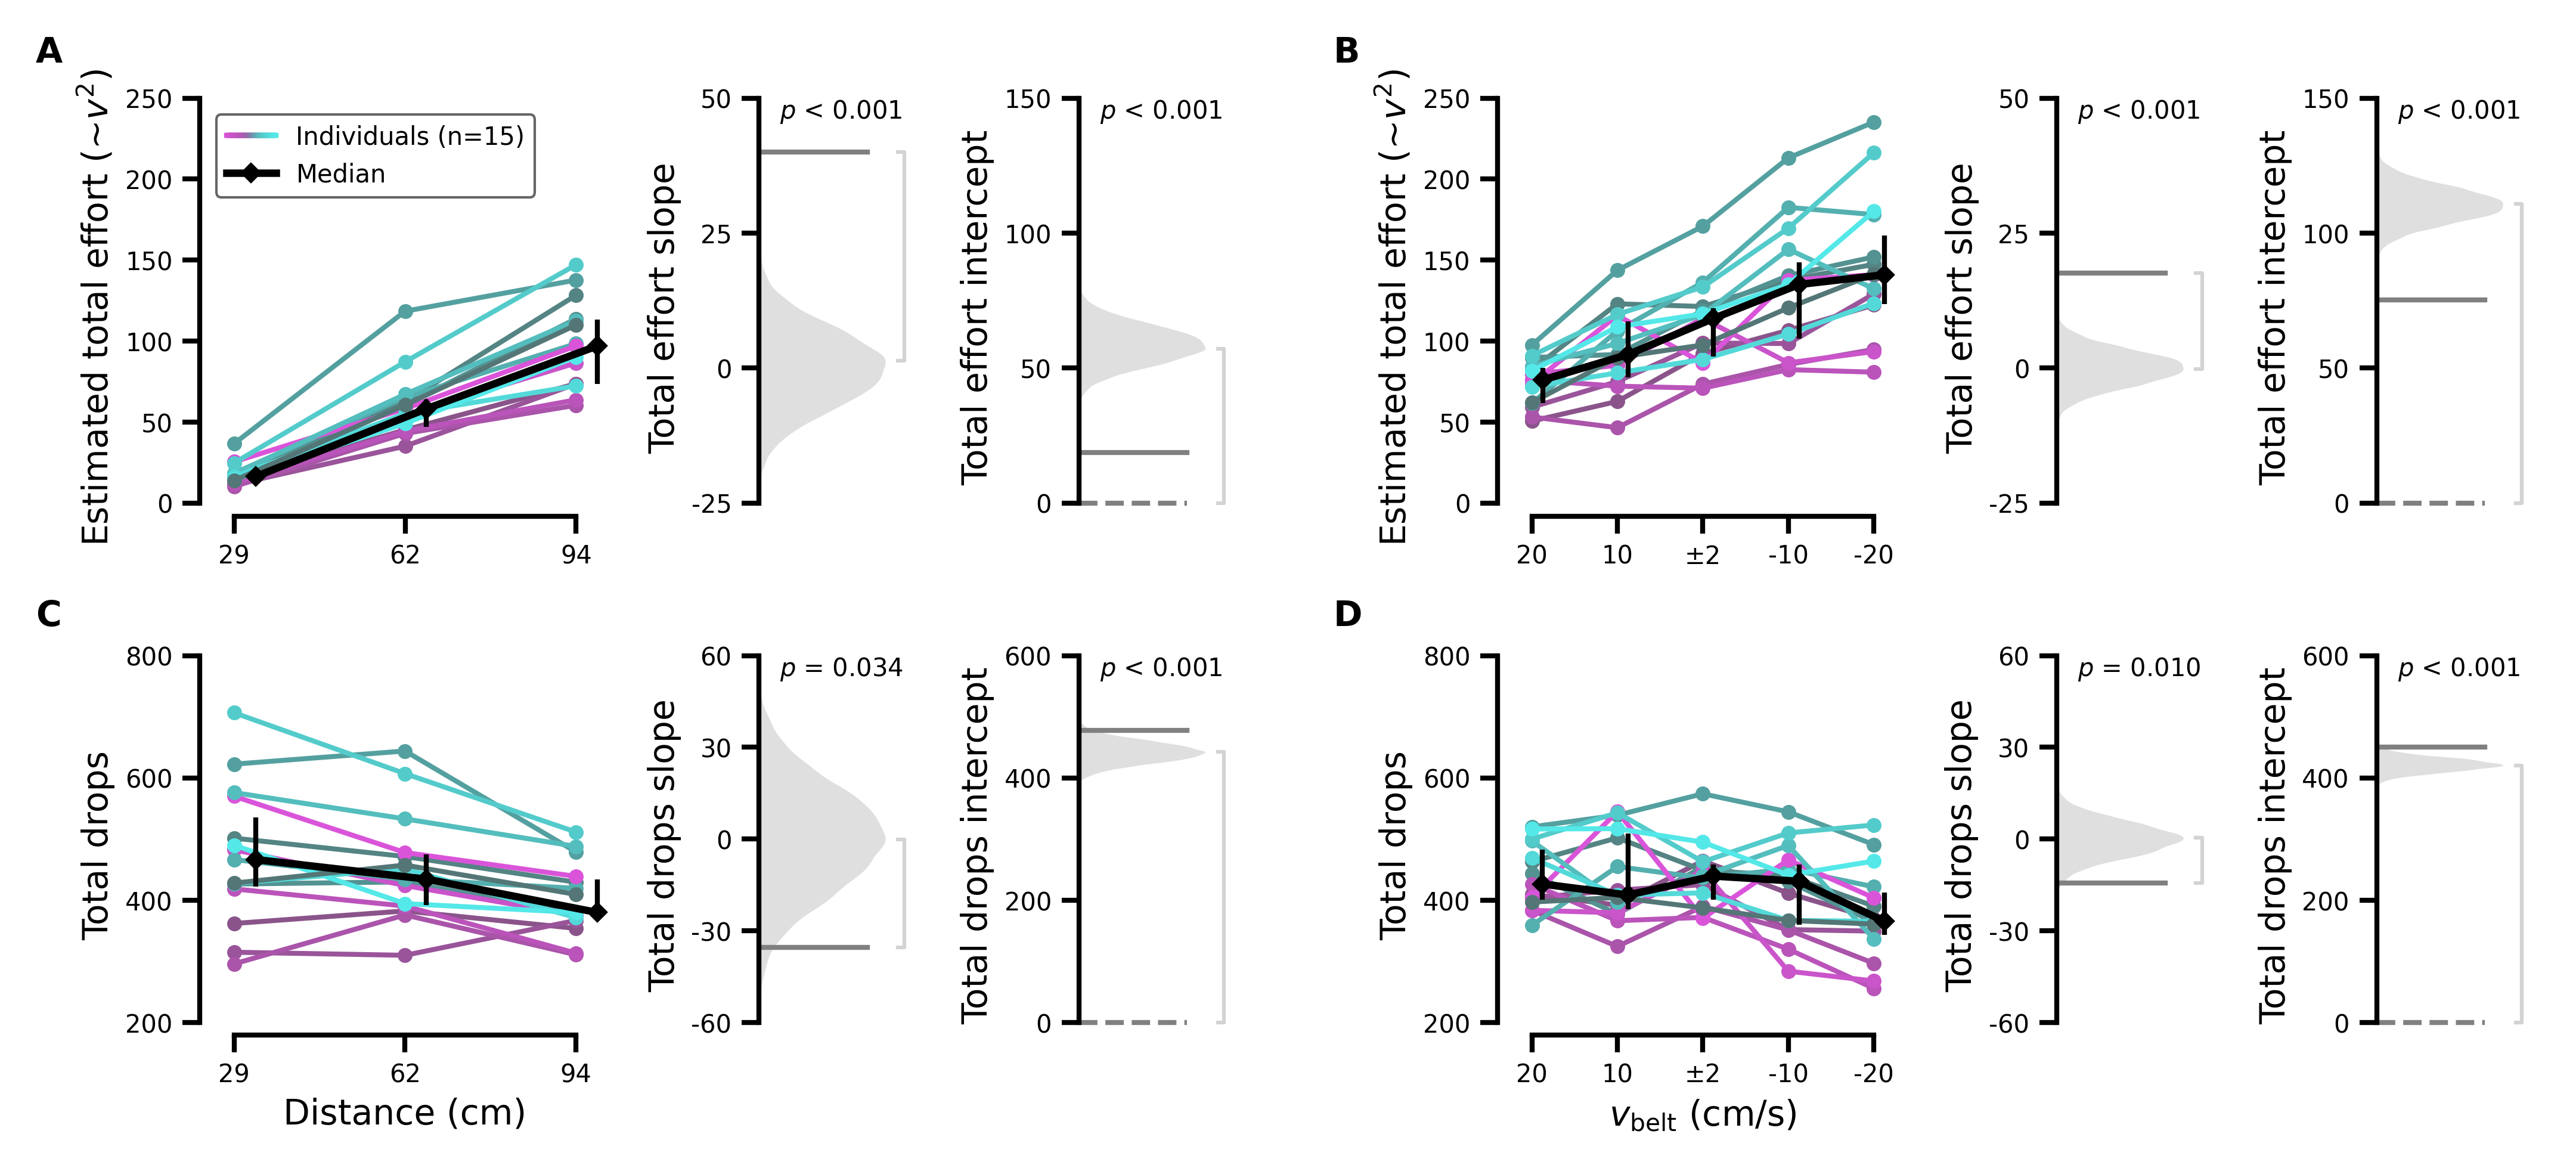

In [6]:
fig = plt.figure(figsize=(cm2inch(18), cm2inch(8)), constrained_layout=True, facecolor='w', dpi=600)

gs0 = fig.add_gridspec(2, 1, wspace=.5, hspace=.5, height_ratios=[1, 1])

row1 = gs0[0].subgridspec(1, 7, wspace=.5, hspace=.5, width_ratios=[2.5, 1, 1, .1, 2.5, 1, 1])
total_effort_distance = plt.subplot(row1[0])
total_effort_distance_slope = plt.subplot(row1[1])
total_effort_distance_intercept = plt.subplot(row1[2])
total_effort_vbelt = plt.subplot(row1[4])
total_effort_vbelt_slope = plt.subplot(row1[5])
total_effort_vbelt_intercept = plt.subplot(row1[6])

row2 = gs0[1].subgridspec(1, 7, wspace=.5, hspace=.5, width_ratios=[2.5, 1, 1, .1, 2.5, 1, 1])
total_drops_distance = plt.subplot(row2[0])
total_drops_distance_slope = plt.subplot(row2[1])
total_drops_distance_intercept = plt.subplot(row2[2])
total_drops_vbelt = plt.subplot(row2[4])
total_drops_vbelt_slope = plt.subplot(row2[5])
total_drops_vbelt_intercept = plt.subplot(row2[6])


FigureS3A(ax=total_effort_distance)
FigureS3B(ax=total_effort_vbelt)
FigureS3C(ax=total_drops_distance, show_xlabel=True)
FigureS3D(ax=total_drops_vbelt, show_xlabel=True)

FigureS3A_stats(ax_slope=total_effort_distance_slope, ax_intercept=total_effort_distance_intercept)
FigureS3B_stats(ax_slope=total_effort_vbelt_slope, ax_intercept=total_effort_vbelt_intercept)
FigureS3C_stats(ax_slope=total_drops_distance_slope, ax_intercept=total_drops_distance_intercept)
FigureS2D_stats(ax_slope=total_drops_vbelt_slope, ax_intercept=total_drops_vbelt_intercept)

for ax, letter in zip([total_effort_distance, total_effort_vbelt, total_drops_distance, total_drops_vbelt], ["A", "B", "C", "D"]):
    old_letter_on_subplot(ax, letter, x_rel=-0.4, y_rel=1.15)

plt.savefig("./Figures_paper/Figure_S3.pdf", facecolor='w', 
        edgecolor='none', bbox_inches='tight', format="pdf", dpi=600)
plt.savefig("./Figures_paper/Figure_S3.svg", facecolor='w', 
        edgecolor='none', bbox_inches='tight', format="svg", dpi=600)